In [0]:
dbutils.fs.ls('dbfs:/FileStore/tables')

Out[49]: [FileInfo(path='dbfs:/FileStore/tables/WEEK7ASS.ipynb', name='WEEK7ASS.ipynb', size=8974, modificationTime=1647880214000),
 FileInfo(path='dbfs:/FileStore/tables/WEEK_8_ASS___1_.ipynb', name='WEEK_8_ASS___1_.ipynb', size=1200916, modificationTime=1648561565000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1645025961000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltri/', name='clinicaltri/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial/', name='clinicaltrial/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019.csv', name='clinicaltrial_2019.csv', size=42400056, modificationTime=1651832598000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019_csv', name='clinicaltrial_2019_csv', size=42400056, modificationTime=1648053134000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019_csv-1.gz', name='clinicaltrial_2019_csv-1.gz', siz

In [0]:
dbutils.fs.ls('dbfs:/FileStore/tables/clinicaltrial_2021.csv')

Out[50]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1651832602000)]

In [0]:
for data in dbutils.fs.head('dbfs:/FileStore/tables/clinicaltrial_2021.csv').splitlines():
    print(data)

[Truncated to first 65536 bytes]
Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions
NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||
NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|
NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|
NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|
NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|
NCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate
NCT02752438|Ankara University|Unknown status|May 2016|Jul 2017|O

In [0]:
myDataFrame = spark.read.options(delimiter='|',header=True).csv('/FileStore/tables/clinicaltrial_2021.csv')

In [0]:
myDataFrame.distinct().count()

Out[53]: 387261

In [0]:
myDataFrame1=myDataFrame.filter("Type != ''").groupBy("Type").count().orderBy("count",ascending = False).withColumnRenamed("count","frequency")

In [0]:
myDataFrame1.show(5)

+--------------------+---------+
|                Type|frequency|
+--------------------+---------+
|      Interventional|   301472|
|       Observational|    77540|
|Observational [Pa...|     8180|
|     Expanded Access|       69|
+--------------------+---------+



In [0]:
from pyspark.sql.functions import *

In [0]:
myDataFrameNew =myDataFrame.select('Conditions').select(split('Conditions', ',').alias('Conditions')).na.drop().withColumn('Conditions',explode('Conditions'))

In [0]:
myDataFrameNew.show(5, truncate = False)

+------------------------+
|Conditions              |
+------------------------+
|Autistic Disorder       |
|Autism Spectrum Disorder|
|Diabetes Mellitus       |
|Tuberculosis            |
|Lung Diseases           |
+------------------------+
only showing top 5 rows



In [0]:
myDataFrame2 =myDataFrame.select('Conditions').select(split('Conditions', ',').alias('Conditions')).na.drop().withColumn('Conditions',explode('Conditions')).groupBy('Conditions').count().orderBy('count',ascending=False)

In [0]:
myDataFrame2.show(5)

+-----------------+-----+
|       Conditions|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



MESH

In [0]:
dbutils.fs.ls('/FileStore/tables/mesh.csv')

Out[61]: [FileInfo(path='dbfs:/FileStore/tables/mesh.csv', name='mesh.csv', size=5295548, modificationTime=1651704959000)]

In [0]:
CreateDFMesh = spark.read.options(delimeter=',', header= True).csv('/FileStore/tables/mesh.csv')

In [0]:
CreateDFMesh.show(5)

+----------+-------------------+
|      term|               tree|
+----------+-------------------+
|Calcimycin|D03.633.100.221.173|
|   A-23187|D03.633.100.221.173|
|   Temefos|D02.705.400.625.800|
|   Temefos|D02.705.539.345.800|
|   Temefos|D02.886.300.692.800|
+----------+-------------------+
only showing top 5 rows



In [0]:
DataFrameTree = CreateDFMesh.withColumn('tree',substring ('tree',0,3).alias('tree'))

In [0]:
DataFrameTree.show(10, truncate = False)

+----------+----+
|term      |tree|
+----------+----+
|Calcimycin|D03 |
|A-23187   |D03 |
|Temefos   |D02 |
|Temefos   |D02 |
|Temefos   |D02 |
|Abate     |D02 |
|Abate     |D02 |
|Abate     |D02 |
|Difos     |D02 |
|Difos     |D02 |
+----------+----+
only showing top 10 rows



In [0]:
AddDataFrame = DataFrameTree.join(myDataFrameNew, DataFrameTree.term == myDataFrameNew.Conditions).select(DataFrameTree["*"],myDataFrameNew["*"])

In [0]:
AddDataFrame.show(20)

+--------------------+----+--------------------+
|                term|tree|          Conditions|
+--------------------+----+--------------------+
|   Autistic Disorder| F03|   Autistic Disorder|
|Autism Spectrum D...| F03|Autism Spectrum D...|
|   Diabetes Mellitus| C19|   Diabetes Mellitus|
|   Diabetes Mellitus| C18|   Diabetes Mellitus|
|        Tuberculosis| C01|        Tuberculosis|
|       Lung Diseases| C08|       Lung Diseases|
|Diverticular Dise...| C06|Diverticular Dise...|
|        Diverticulum| C23|        Diverticulum|
|        Diverticulum| C06|        Diverticulum|
|      Diverticulosis| C23|      Diverticulosis|
|      Diverticulosis| C06|      Diverticulosis|
|              Asthma| C20|              Asthma|
|              Asthma| C08|              Asthma|
|              Asthma| C08|              Asthma|
|              Asthma| C08|              Asthma|
|     Hypoventilation| C23|     Hypoventilation|
|     Hypoventilation| C08|     Hypoventilation|
|            Lymphom

In [0]:
AddDataFrame1 = AddDataFrame.select('tree').alias('tree').na.drop().groupBy('tree').count().orderBy('count', ascending = False)


In [0]:
AddDataFrame1.show(5)

+----+------+
|tree| count|
+----+------+
| C04|143994|
| C23|136079|
| C01|106674|
| C14| 94523|
| C10| 92310|
+----+------+
only showing top 5 rows



In [0]:
dbutils.fs.ls('/FileStore/tables/pharma.csv')

Out[70]: [FileInfo(path='dbfs:/FileStore/tables/pharma.csv', name='pharma.csv', size=678999, modificationTime=1651704940000)]

In [0]:
SponsorDF = spark.read.options(delimiter= ',', header = True).csv('/FileStore/tables/pharma.csv')

In [0]:
SponsorDF.show(15)

+--------------------+--------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+------------------+---------------------+-----+---------------+-----------------------------+------------------+--------------+------------+--------------------+-----+----------+--------------------+--------------------+------------------+-------------------+---------------------------+------------------------+---------------------------+--------------------+--------------------+
|             Company|      Parent_Company|Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|       Offense_Group|     Primary_Offense|   Secondary_Offense|         Description|Level_of_Government|  Action_Type|              Agency|    C

In [0]:
AddSponsorDF1 = myDataFrame.join(SponsorDF, myDataFrame.Sponsor == SponsorDF.Parent_Company,'left')

In [0]:
AddSponsorDF1.show(2)

+-----------+--------------------+----------+--------+----------+--------------+----------+--------------------+-------------+-------+--------------+--------------+------------------------+---------------------------------------------------------+------------+------------+-------------+---------------+-----------------+-----------+-------------------+-----------+------+--------------+---------------------+-----+-------+-----------------------------+------------------+--------------+----+-------+----+----------+-----------------+--------------------+------------------+-------------------+---------------------------+------------------------+---------------------------+-----------+-----+
|         Id|             Sponsor|    Status|   Start|Completion|          Type|Submission|          Conditions|Interventions|Company|Parent_Company|Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|Offense_Group|Primary_Offense|Sec

In [0]:
AddSponsorDF2 = AddSponsorDF1.select('Sponsor','Parent_Company' ).where ('Parent_Company is null').groupBy(['Sponsor']).count().orderBy(['count'],ascending = False)

In [0]:
AddSponsorDF2.show(10)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



STUDIES COMPLETED BY MONTH

In [0]:
StudCompMon = myDataFrame.filter(myDataFrame.Completion.endswith('2021')).filter(myDataFrame.Status=='Completed').groupBy('Completion').count().sort(desc('count'))

In [0]:
StudCompMon1= StudCompMon.orderBy('Completion').withColumn('Completion',split(col('Completion'),' ').getItem(0)).sort('Completion', inplace= True)

In [0]:
from pyspark.sql.functions  import unix_timestamp
StudCompMon2=StudCompMon1.sort(unix_timestamp(col('Completion'),"MMM"))

In [0]:
StudCompMon2.show()

+----------+-----+
|Completion|count|
+----------+-----+
|       Jan| 1131|
|       Feb|  934|
|       Mar| 1227|
|       Apr|  967|
|       May|  984|
|       Jun| 1094|
|       Jul|  819|
|       Aug|  700|
|       Sep|  528|
|       Oct|  187|
+----------+-----+



Out[81]: <AxesSubplot:xlabel='Completion'>

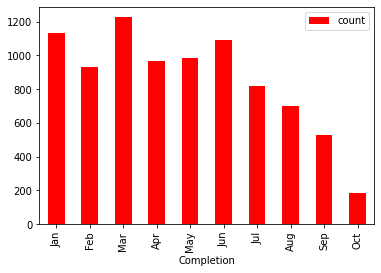

In [0]:
StudCompMon2.toPandas().plot.bar(x='Completion',y='count', color= 'red' )

finding location where clinical sponsor are located and the count based on clinical sponsor on each location

In [0]:
locationDF = SponsorDF.select(['Parent_Company','City']).filter(SponsorDF.City.isNotNull())

In [0]:
sponsorcountdf= myDataFrame.select(['Sponsor']).groupBy('Sponsor').count()
sponsorcountdf.show()

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|University Hospit...|  128|
|Federal Universit...|   84|
|Second Affiliated...|   17|
|    Mosaic Life Care|    2|
|Duke-NUS Graduate...|   48|
|Beijing Neurosurg...|   11|
|University of Okl...|  284|
|Milton S. Hershey...|  384|
|  Ryerson University|   45|
|Mae Fah Luang Uni...|   14|
|   Goethe University|   61|
|The Ninth Hospita...|    1|
|Guangzhou Univers...|   37|
|Qazvin University...|   33|
|  Aeris Therapeutics|   18|
|   United Biomedical|    4|
|University of Nov...|    6|
|Alios Biopharma Inc.|   21|
|Peter MacCallum C...|   53|
|Bronx VA Medical ...|   14|
+--------------------+-----+
only showing top 20 rows



In [0]:
sponsorcountdf1=sponsorcountdf.join(locationDF, sponsorcountdf.Sponsor == locationDF.Parent_Company,'inner').select(['Sponsor','City','count'])

In [0]:

grouplocation = sponsorcountdf.join(locationDF, sponsorcountdf.Sponsor == locationDF.Parent_Company,'inner').select(['Sponsor','City','count'])

######This shows pharmaceutical sponsor of clinical trial are located in more than one city and the numbers of there clinical trials.
GlaxoSmithkline has the highest number.

In [0]:
grouplocation = sponsorcountdf.join(locationDF, sponsorcountdf.Sponsor == locationDF.Parent_Company,'inner').select(['Sponsor','City','count']).orderBy('count',ascending = False)
grouplocation.display(truncate = False)

Sponsor,City,count
GlaxoSmithKline,Memphis,3378
GlaxoSmithKline,Hamilton,3378
GlaxoSmithKline,East Durham,3378
GlaxoSmithKline,King of Prussia,3378
GlaxoSmithKline,KING OF PRUSSIA,3378
AstraZeneca,SMITHFIELD,2691
AstraZeneca,SHEPHEDSVILLE,2691
AstraZeneca,Wayne,2691
Pfizer,Groton,2645
Pfizer,Groton,2645
